<a href="https://colab.research.google.com/github/demotu/gait_score/blob/main/notebooks/gps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Gait Score Neuropathy (gait_score): GPS calculation

## Python setup

In [1]:
#import libraries
import sys, os
from pathlib import Path  # file and directory paths in Python
import glob  # Unix style pathname pattern expansion
from datetime import datetime
import numpy as np  # large, multi-dimensional numeric arrays and matrices
import pandas as pd  # labelled tables with numeric and string data
import matplotlib  # data visualization
import matplotlib.pyplot as plt  # data visualization
import seaborn as sns  # data visualization
import xarray as xr  # labelled multi-dimensional arrays
from tqdm.notebook import tqdm  # progress bar
from IPython.display import display, Math, Latex  # IPython formatting
import scipy as sp  # collection of mathematical algorithms and convenience functions built on NumPy
if os.getenv("COLAB_RELEASE_TAG"):
    !pip install -q ipywidgets  # Jupyter Widgets
    from google.colab import output
    output.enable_custom_widget_manager()

print(f'Python {sys.version} on {sys.platform}', f' numpy {np.__version__}',
      f' scipy {sp.__version__}', f' pandas {pd.__version__}',
      datetime.now().strftime("%d/%m/%Y %H:%M:%S"), sep='\n')

Python 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0] on linux
 numpy 1.26.4
 scipy 1.13.1
 pandas 2.2.2
24/10/2024 19:41:15


In [2]:
# Environment configuration
sns.set_context('notebook', font_scale=1, rc={"lines.linewidth": 2})
sns.set_style('whitegrid')
colors = sns.color_palette()
display(colors)
style = [{'selector': 'th', 'props': [('text-align', 'left')]},
         {'selector': 'caption', 'props': [('font-weight', 'bold'), ('color', 'blue'), ('font-size', '120%')]}]
xr.set_options(keep_attrs=True)
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

## Helping functions

In [3]:
def plot_subjects(da, path2, metadata2, group, assessment, NS):
    """3x3 suplots with joint angles of all subjects for the GPS calculation.
    """

    time = da['Time'].values
    joints = list(da.Joint.values)
    axes = list(da.Axis.values)
    # angle convention
    planes  = ['Sagittal', 'Frontal', 'Transverse']
    labels = [['Pelvic Tilt ($^o$)\nposterior(-)/anterior(+)', 'Pelvic Obliquity ($^o$)\ndown(-)/up(+)', 'Pelvic Rotation ($^o$)\nexternal(-)/internal(+)'],
              ['Hip Flexion ($^o$)\nextension(-)/flexion(+)', 'Hip Adduction ($^o$)\nabduction(-)/adduction(+)', 'Hip Rotation ($^o$)\nexternal(-)/internal(+)'],
              ['Knee Flexion ($^o$)\nextension(-)/flexion(+)', 'Ankle Dorsiflexion ($^o$)\nplantarflexion(-)/dorsiflexion(+)', 'Foot Progression ($^o$)\ninternal(-)/external(+)']]

    fig, axs = plt.subplots(3, 3, figsize=(12, 9), sharex=True)
    text = f'{path2.name}, G{group}{assessment}:'
    fig.suptitle(f'{text} Subjects\' joint angles during walking (median across trials, {NS} subjects)', fontsize=12)
    for j, joint in enumerate(joints):
        for xyz, eixo in enumerate(axes):
            axs[j, xyz].axhline(y=0, color=[0, 0, 0, .6], linestyle='-', lw=1, zorder=-1)
            axs[j, xyz].axvline(x=np.round(np.nanmean(metadata2['Foot Off'])), color=[0, 0, 0, .6], linestyle=':', lw=1, zorder=-1)
            axs[j, xyz].plot(time, da.sel(Joint=joints[j], Axis=axes[xyz]), alpha=.8, lw=2)

            axs[j, xyz].set_ylabel(labels[j][xyz], fontsize=12)
            axs[j, xyz].set_xlim([0, 100])
            if xyz == 0:
                axs[j, xyz].margins(y=0.25)
            else:
                axs[j, xyz].margins(y=0.25)
            axs[j, xyz].grid(False)
            axs[j, xyz].xaxis.set_ticks_position('none')
            axs[j, xyz].yaxis.set_ticks_position('none')
            axs[j, xyz].tick_params(axis='both', which='major', pad=0)
            if j == 2 and xyz == 1:
                axs[j, xyz].set_xlabel('Gait cycle [%]', fontsize=14)
                axs[j, xyz].xaxis.set_label_coords(.5, -.2)

    fig.align_ylabels()
    #axs[0, 0].legend(loc='best', framealpha=1, frameon=False)
    fig.tight_layout()
    try:
        fig.savefig(f'{path2}AnglesSubjectsG{group}{assessment}.png', bbox_inches='tight')
    except:
        print('Figure not saved in the cloud.')
    plt.show()


def plot_subjects_m_std(dam, dastd, path2, metadata2, group, assessment, NS):
    """3x3 suplots with average joint angles of subjects for the GPS calculation.
    """
    time = dam['Time'].values
    joints = list(dam.Joint.values)
    axes = list(dam.Axis.values)
    # angle convention
    planes  = ['Sagittal', 'Frontal', 'Transverse']
    labels = [['Pelvic Tilt ($^o$)\nposterior(-)/anterior(+)',
               'Pelvic Obliquity ($^o$)\ndown(-)/up(+)',
               'Pelvic Rotation ($^o$)\nexternal(-)/internal(+)'],
              ['Hip Flexion ($^o$)\nextension(-)/flexion(+)',
               'Hip Adduction ($^o$)\nabduction(-)/adduction(+)',
               'Hip Rotation ($^o$)\nexternal(-)/internal(+)'],
              ['Knee Flexion ($^o$)\nextension(-)/flexion(+)',
               'Ankle Dorsiflexion ($^o$)\nplantarflexion(-)/dorsiflexion(+)',
               'Foot Progression ($^o$)\ninternal(-)/external(+)']]

    fig, axs = plt.subplots(3, 3, figsize=(12, 9), sharex=True)
    text = f'{path2.name}, G{group}{assessment}:'
    fig.suptitle(f'{text} Joint angles during walking (mean$\\pm$1SD across subjects, {NS} subjects)', fontsize=14)
    for j, joint in enumerate(joints):
        for xyz, eixo in enumerate(axes):
            axs[j, xyz].axhline(y=0, color=[0, 0, 0, .6], linestyle='-', lw=1, zorder=-1)
            axs[j, xyz].axvline(x=np.round(np.nanmean(metadata2['Foot Off'])), color=[0, 0, 0, .6], linestyle=':', lw=1, zorder=-1)
            axs[j, xyz].plot(time, dam.sel(Joint=joints[j], Axis=axes[xyz]), color=colors[0], alpha=.8, lw=3)
            axs[j, xyz].fill_between(time,
                                     dam.sel(Joint=joints[j], Axis=axes[xyz]) + dastd.sel(Joint=joints[j], Axis=axes[xyz]),
                                     dam.sel(Joint=joints[j], Axis=axes[xyz]) - dastd.sel(Joint=joints[j], Axis=axes[xyz]),
                                     facecolor=colors[0], alpha=.6, edgecolor='none')

            axs[j, xyz].set_ylabel(labels[j][xyz], fontsize=12)
            axs[j, xyz].set_xlim([0, 100])
            if xyz == 0:
                axs[j, xyz].margins(y=0.25)
            else:
                axs[j, xyz].margins(y=0.25)
            axs[j, xyz].grid(False)
            axs[j, xyz].xaxis.set_ticks_position('none')
            axs[j, xyz].yaxis.set_ticks_position('none')
            axs[j, xyz].tick_params(axis='both', which='major', pad=0)
            if j == 2 and xyz == 1:
                axs[j, xyz].set_xlabel('Gait cycle [%]', fontsize=14)
                axs[j, xyz].xaxis.set_label_coords(.5, -.2)

    fig.align_ylabels()
    #axs[0, 0].legend(loc='best', framealpha=1, frameon=False)
    fig.tight_layout()
    try:
        fig.savefig(f'{path2}Angles_m_std_SubjectsG{group}{assessment}.png', bbox_inches='tight')
    except:
        print('Figure not saved in the cloud.')
    plt.show()


## The Gait Proﬁle Score (GPS)

Baker et al. (2009) proposed the Gait Proﬁle Score (GPS) as an index of overall gait pathology.  
To calculate the GPS, first the Gait Variable Score (GVS) is determined as the RMS difference between a gait variable of a subject and the average of this gait variable for a sample with no gait pathology (reference).  
The Gait Proﬁle Score (GPS) is the RMS average of all GVS values.  
The Movement Analysis Proﬁle (MAP) is a plot with all GVS values and the GPS value of the subject and of the reference sample.  
Baker et al. suggested nine angular variables of gait for using in the GPS calculation: Pelvic tilt, obliquity and rotation, Hip flexion, abduction and rotation, knee flexion, Ankle dorsiflexion and Foot progression.  
Baker et al. also suggested to calculate the GVS of the angles for both sides (left and right) with the exception of the pelvic angles, which usualy have the same values for both sides in gait analysis.

### Root mean square (RMS) and RMS deviation (RMSD)

The root mean square (RMS) of a set of values (sample) is the square root of the arithmetic mean of the squares of the sample:

$$ \mathrm{RMS} = \sqrt{ \sum_{i=1}^N \frac{x_i^2}{N} } $$

The root-mean-square deviation (RMSD) or root mean square error (RMSE) is the square root of the average of squared deviations between two sets of values (samples) $x$ and $y$ of size $N$:

$$ \mathrm{RMSD} = \sqrt{ \sum_{i=1}^N \frac{(y_i-x_i)^2}{N} } $$


In [4]:
RMSD = lambda x, y: np.sqrt(np.nanmean((y - x)**2, axis=0))  #  x and y must be arrays

### Reference data

In [5]:
# reference data from Claudiane
if os.getenv("COLAB_RELEASE_TAG"):
    url = 'https://raw.githubusercontent.com/demotu/gait_score/refs/heads/main/data/Claudiane/angles_ref_gp19b.csv'
    ref_data = pd.read_csv(url, index_col=0)
else:
    ref_data = pd.read_csv('./../data/Claudiane/angles_ref_gp19b.csv', index_col=0)

### Project RonaldJane

In [6]:
path2 = Path('./../data/RonaldoJane/')
if os.getenv("COLAB_RELEASE_TAG"):
    url = f'https://raw.githubusercontent.com/demotu/gait_score/refs/heads/main/data/{path2.name}/metadata_{path2.name}.csv'
    print(f'Loading data from {url}')
    metadata = pd.read_csv(url, sep=',', header=0, index_col=0, dtype={'Assessment':'str'})
else:
    metadata = pd.read_csv(path2 /  f'metadata_{path2.name}.csv', sep=',', header=0, index_col=0, dtype={'Assessment':'str'})
variable = 'Angle'
group = 1
assessment = 'T00'
metadata2 = metadata.query('Group  == @group & Assessment == @assessment')
display(metadata2)
if os.getenv("COLAB_RELEASE_TAG"):
    url = f'https://github.com/demotu/gait_score/raw/refs/heads/main/data/{path2.name}/{variable}_G{group}{assessment}_{path2.name}.nc'
    #print(f'Loading data from {url}')
    !wget {url}
    da = xr.open_dataarray(f'{variable}_G{group}{assessment}_{path2.name}.nc')
else:
    da = xr.open_dataarray(f'{path2 / variable}_G{group}{assessment}_{path2.name}.nc')
display(da)
#subjects = metadata2.drop_duplicates('S')['Subject'].values
#NS = subjects.size
subjects = da.Subject.values
NS = subjects.size
labels = ['Pelvic Tilt', 'Pelvic Obliquity', 'Pelvic Rotation',
          'Hip Flexion', 'Hip Adduction', 'Hip Rotation',
          'Knee Flexion', 'Ankle Dorsiflexion', 'Foot Progression', 'GPS']
print(f'Numbers of subjects: {NS}')

Loading data from https://raw.githubusercontent.com/demotu/gait_score/refs/heads/main/data/RonaldoJane/metadata_RonaldoJane.csv


,Filename,Subject,Group,Assessment,Trial,Mass,Height,LegLength,FootLength,Cadence,...,Stride Time,Foot Off,Stride Length,Duration,Stance Time,Side,G,A,S,T
0,S_S16_T00_9,S16,1,T00,9,76.5,1.550,0.746,0.194,114.504,...,1.048,71.947,1.077,1.048,0.754,L,0,0,0,0
1,S_S22_T00_2,S22,1,T00,2,73.8,1.595,0.755,0.185,109.290,...,1.098,65.756,1.102,1.098,0.722,R,0,0,1,0
2,S_S22_T00_5,S22,1,T00,5,73.8,1.595,0.755,0.185,112.045,...,1.071,64.986,1.097,1.071,0.696,R,0,0,1,1
3,S_S22_T00_6,S22,1,T00,6,73.8,1.595,0.755,0.192,109.689,...,1.094,64.442,1.045,1.094,0.705,L,0,0,1,2
4,S_S22_T00_10,S22,1,T00,10,73.8,1.595,0.755,0.185,108.011,...,1.111,63.906,1.136,1.111,0.710,R,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,S_S75_T00_9,S75,1,T00,9,79.7,1.580,0.762,0.188,106.101,...,1.131,62.599,1.091,1.131,0.708,L,0,0,27,4
184,S_S75_T00_12,S75,1,T00,12,79.7,1.580,0.762,0.183,110.193,...,1.089,62.626,1.136,1.089,0.682,R,0,0,27,5
185,S_S75_T00_13,S75,1,T00,13,79.7,1.580,0.762,0.183,112.782,...,1.064,62.312,1.108,1.064,0.663,R,0,0,27,6
186,S_S75_T00_14,S75,1,T00,14,79.7,1.580,0.762,0.183,109.689,...,1.094,63.163,1.119,1.094,0.691,R,0,0,27,7


--2024-10-24 19:41:16--  https://github.com/demotu/gait_score/raw/refs/heads/main/data/RonaldoJane/Angle_G1T00_RonaldoJane.nc
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/demotu/gait_score/refs/heads/main/data/RonaldoJane/Angle_G1T00_RonaldoJane.nc [following]
--2024-10-24 19:41:16--  https://raw.githubusercontent.com/demotu/gait_score/refs/heads/main/data/RonaldoJane/Angle_G1T00_RonaldoJane.nc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103920 (101K) [application/octet-stream]
Saving to: ‘Angle_G1T00_RonaldoJane.nc.2’

Angle_G1T00_Ronaldo 100%[===================>] 101.48K  --.-KB/s    i

<xarray.DataArray 'Angle' (Time: 51, Joint: 3, Axis: 3, Subject: 28)> Size: 103kB
[12852 values with dtype=float64]
Coordinates:
  * Time     (Time) float64 408B 0.0 2.0 4.0 6.0 8.0 ... 94.0 96.0 98.0 100.0
  * Subject  (Subject) object 224B 'S16' 'S22' 'S23' 'S24' ... 'S73' 'S74' 'S75'
  * Joint    (Joint) object 24B 'Pelvis' 'Hip' 'Knee'
  * Axis     (Axis) object 24B 'ML' 'AP' 'VT'
Attributes:
    units:    deg

Numbers of subjects: 28


### Plots

Figure not saved in the cloud.


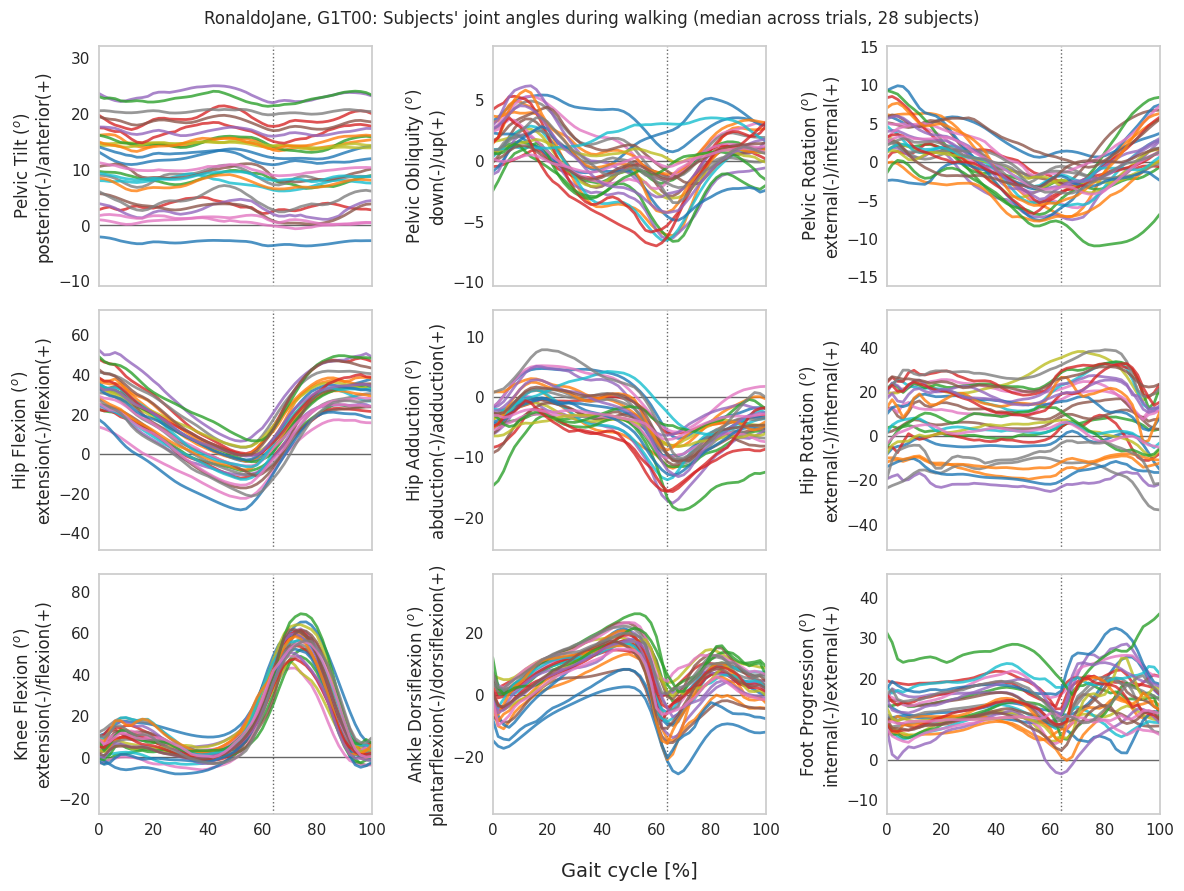

In [7]:
plot_subjects(da, path2, metadata2, group, assessment, NS)

Figure not saved in the cloud.


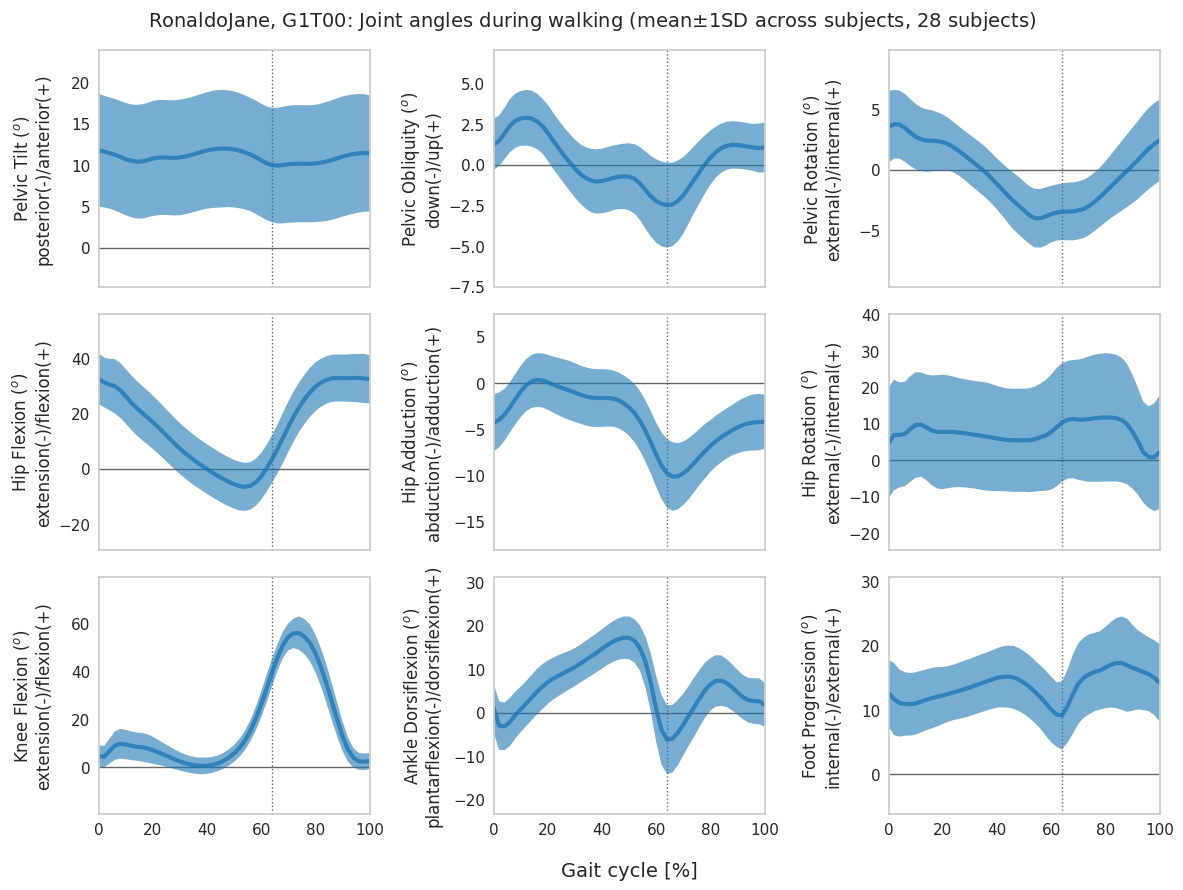

In [8]:
dam = da.reduce(np.nanmean, dim='Subject')
dastd = da.reduce(np.nanstd, ddof=1, dim='Subject')#/np.sqrt(NS)

plot_subjects_m_std(dam, dastd, path2, metadata2, group, assessment, NS)

### GPS calculation

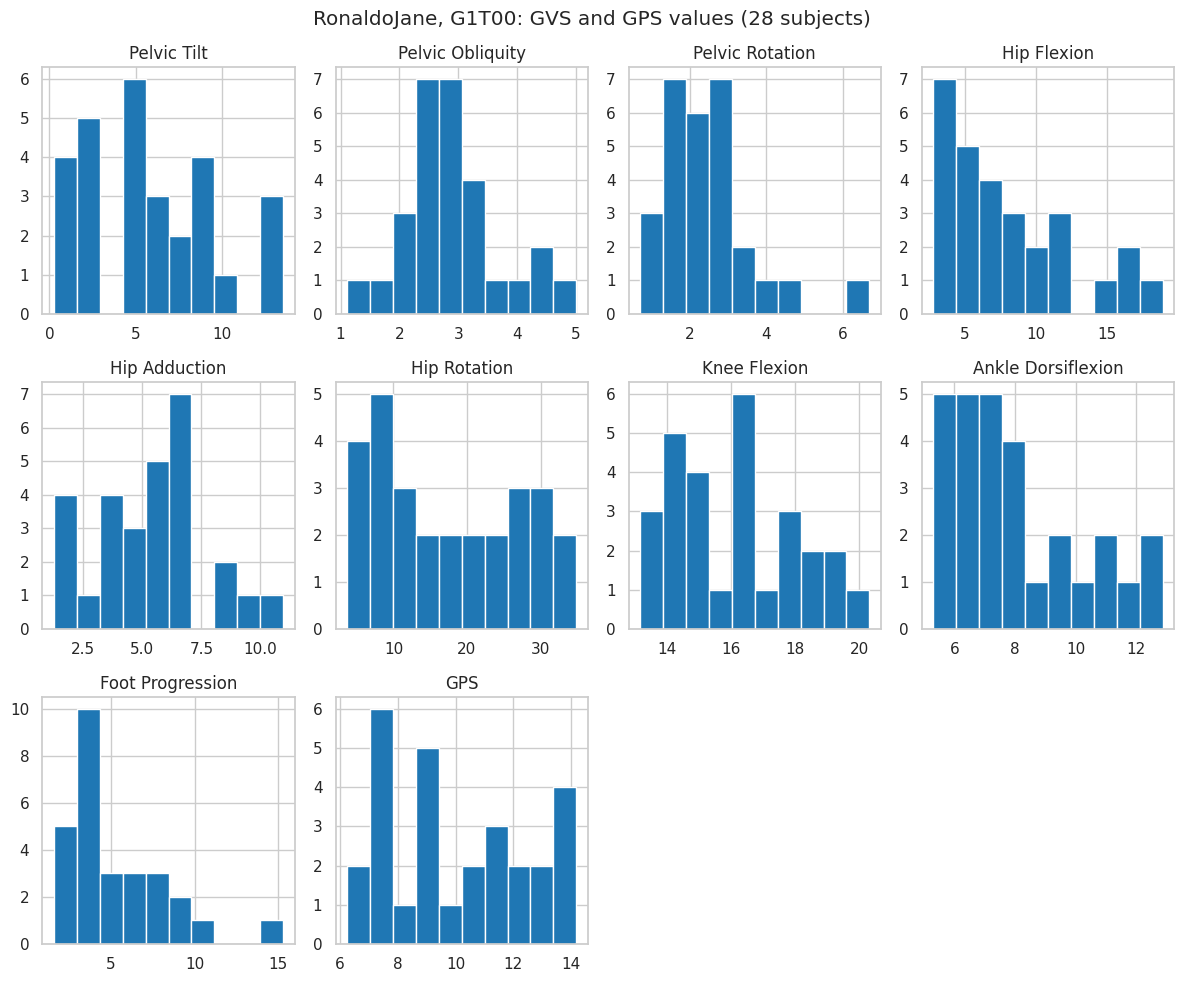

In [9]:
time = da['Time'].values
gvs = np.full((NS, len(labels)), np.nan)
for s, subject in enumerate(subjects):
    x = da.sel(Subject=subject).values.reshape(time.size, 9)
    gvs[s, :-1] = RMSD(x, ref_data.values)

gvs[:, -1] = np.sqrt(np.mean(gvs[:, :-1]**2, axis=1))
gvs = pd.DataFrame(data=gvs, index=subjects, columns=labels)
gvs_m = np.sqrt(np.mean(gvs**2, axis=0))
gvs_std = np.sqrt(np.std(gvs**2, axis=0, ddof=1))
gvs_m = np.percentile(gvs, 50, axis=0)
gvs_std = np.percentile(gvs, [25, 75], axis=0)

gvs.hist(layout=(3, 4), figsize=(12, 10))
plt.suptitle(f'{path2.name}, G{group}{assessment}: GVS and GPS values ({NS} subjects)')
plt.tight_layout()

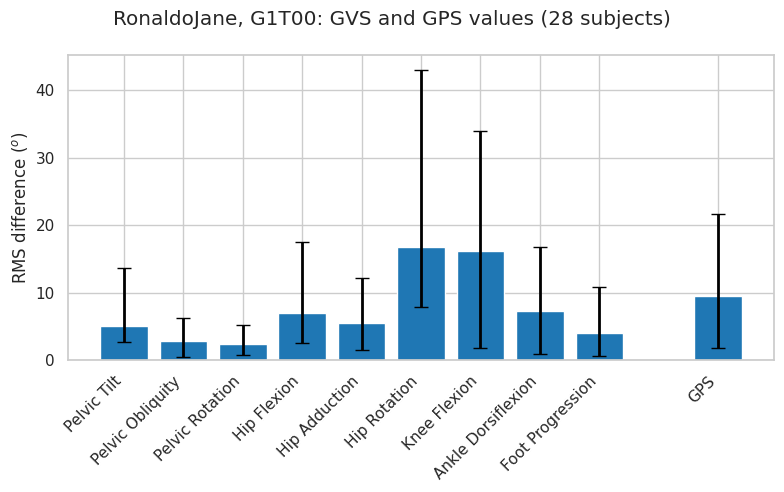

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5))
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 11]

axs.bar(x=x, height=gvs_m, yerr=gvs_std, width=.8, edgecolor=None, capsize=5)

axs.set_ylabel('RMS difference ($^o$)')
axs.set_xlabel('')
axs.xaxis.set_ticks(x)
axs.set_xticklabels(labels, rotation=45, ha='right')
axs.grid(True)
plt.suptitle(f'{path2.name}, G{group}{assessment}: GVS and GPS values ({NS} subjects)')
plt.tight_layout()
plt.show()

### Project Erica

In [11]:
path2 = Path(r'./../data/Erica/')
if os.getenv("COLAB_RELEASE_TAG"):
    url = f'https://raw.githubusercontent.com/demotu/gait_score/refs/heads/main/data/{path2.name}/metadata_{path2.name}.csv'
    print(f'Loading data from {url}')
    metadata = pd.read_csv(url, sep=',', header=0, index_col=0, dtype={'Assessment':'str'})
else:
    metadata = pd.read_csv(path2 /  f'metadata_{path2.name}.csv', sep=',', header=0, index_col=0, dtype={'Assessment':'str'})
variable = 'Angle'
group = 1
assessment = 'T00'
metadata2 = metadata.query('Group  == @group & Assessment == @assessment')
display(metadata2)
if os.getenv("COLAB_RELEASE_TAG"):
    url = f'https://github.com/demotu/gait_score/raw/refs/heads/main/data/{path2.name}/{variable}_G{group}{assessment}_{path2.name}.nc'
    !wget {url}
    da = xr.open_dataarray(f'{variable}_G{group}{assessment}_{path2.name}.nc')
else:
    da = xr.open_dataarray(f'{path2 / variable}_G{group}{assessment}_{path2.name}.nc')
display(da)
#subjects = metadata2.drop_duplicates('S')['Subject'].values
#NS = subjects.size
subjects = da.Subject.values
NS = subjects.size
labels = ['Pelvic Tilt', 'Pelvic Obliquity', 'Pelvic Rotation',
          'Hip Flexion', 'Hip Adduction', 'Hip Rotation',
          'Knee Flexion', 'Ankle Dorsiflexion', 'Foot Progression', 'GPS']
print(f'Numbers of subjects: {NS}')

Loading data from https://raw.githubusercontent.com/demotu/gait_score/refs/heads/main/data/Erica/metadata_Erica.csv


,Filename,Subject,Group,Assessment,Trial,Mass,Height,LegLength,FootLength,Cadence,...,Stride Time,Foot Off,Stride Length,Duration,Stance Time,Side,G,A,S,T
0,C_S02_T00_2,S02,1,T00,2,85.2,1.60,0.746,0.191,103.448,...,1.160,59.483,1.158,1.190,0.708,R,0,0,0,0
1,C_S02_T00_8,S02,1,T00,8,NaN,NaN,NaN,NaN,121.581,...,0.987,100.000,1.127,0.980,0.980,L,0,0,0,1
2,C_S04_T00_2,S04,1,T00,2,98.7,1.59,0.815,0.189,103.093,...,1.164,61.340,0.997,1.164,0.714,R,0,0,1,0
3,C_S04_T00_3,S04,1,T00,3,98.7,1.59,0.815,0.193,111.732,...,1.074,60.894,1.059,1.074,0.654,L,0,0,1,1
4,C_S04_T00_4,S04,1,T00,4,98.7,1.59,0.815,0.193,NaN,...,NaN,100.000,NaN,1.110,1.110,L,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,C_S58_T00_03,S58,1,T00,3,63.8,1.67,0.844,0.205,110.396,...,1.087,60.534,1.169,1.087,0.658,R,0,0,22,0
114,C_S58_T00_15,S58,1,T00,15,63.8,1.67,0.844,0.206,122.699,...,0.978,61.861,1.240,0.978,0.605,L,0,0,22,1
115,C_S58_T00_21,S58,1,T00,21,63.8,1.67,0.844,0.205,117.878,...,1.018,59.430,1.230,1.018,0.605,R,0,0,22,2
116,C_S58_T00_22,S58,1,T00,22,63.8,1.67,0.844,0.205,116.732,...,1.028,60.992,1.190,1.028,0.627,R,0,0,22,3


--2024-10-24 19:41:51--  https://github.com/demotu/gait_score/raw/refs/heads/main/data/Erica/Angle_G1T00_Erica.nc
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/demotu/gait_score/refs/heads/main/data/Erica/Angle_G1T00_Erica.nc [following]
--2024-10-24 19:41:51--  https://raw.githubusercontent.com/demotu/gait_score/refs/heads/main/data/Erica/Angle_G1T00_Erica.nc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89220 (87K) [application/octet-stream]
Saving to: ‘Angle_G1T00_Erica.nc.1’

Angle_G1T00_Erica.n 100%[===================>]  87.13K  --.-KB/s    in 0.02s   

2024-10-24 19:41:51 (4.40 MB/s) 

<xarray.DataArray 'Angle' (Time: 51, Joint: 3, Axis: 3, Subject: 24)> Size: 88kB
[11016 values with dtype=float64]
Coordinates:
  * Time     (Time) float64 408B 0.0 2.0 4.0 6.0 8.0 ... 94.0 96.0 98.0 100.0
  * Subject  (Subject) object 192B 'S02' 'S04' 'S06' 'S07' ... 'S57' 'S58' 'S60'
  * Joint    (Joint) object 24B 'Pelvis' 'Hip' 'Knee'
  * Axis     (Axis) object 24B 'ML' 'AP' 'VT'
Attributes:
    units:    deg

Numbers of subjects: 24


### Plots

Figure not saved in the cloud.


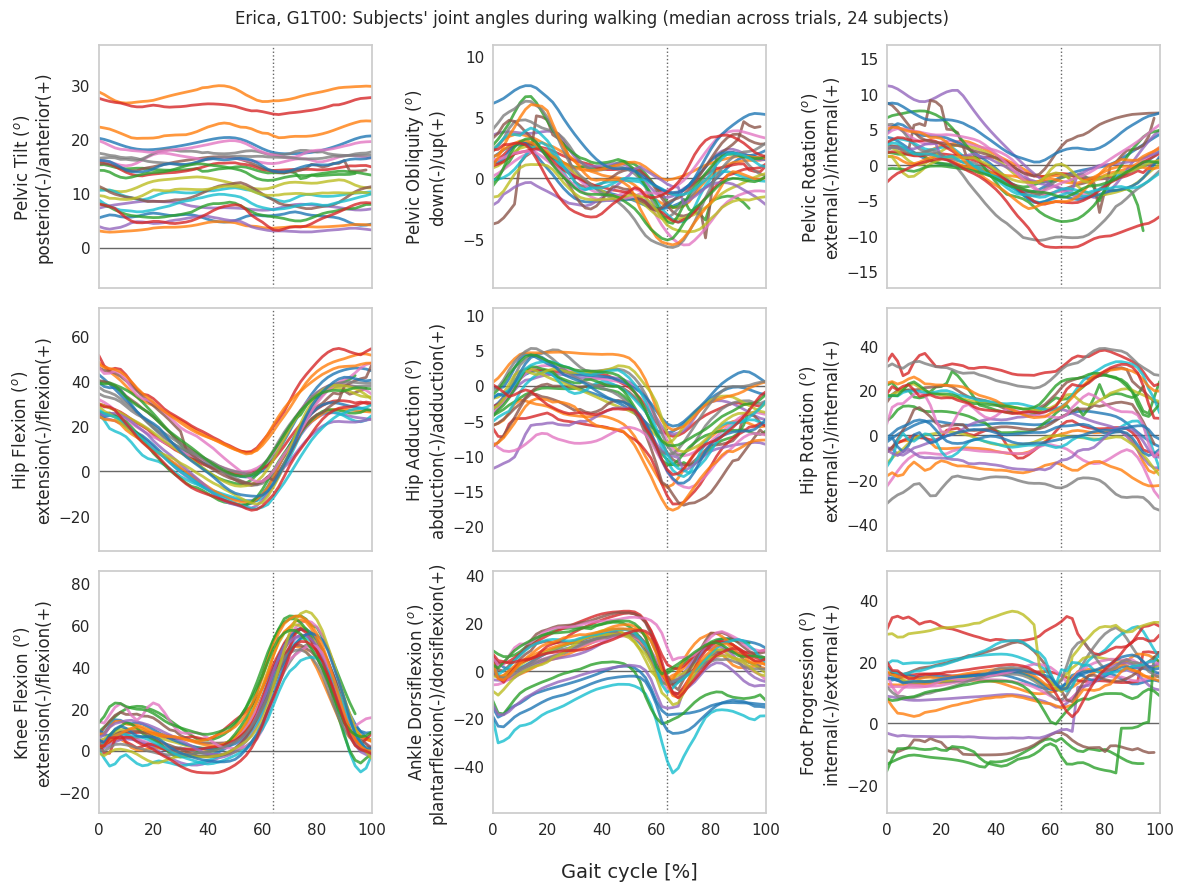

In [12]:
plot_subjects(da, path2, metadata2, group, assessment, NS)

Figure not saved in the cloud.


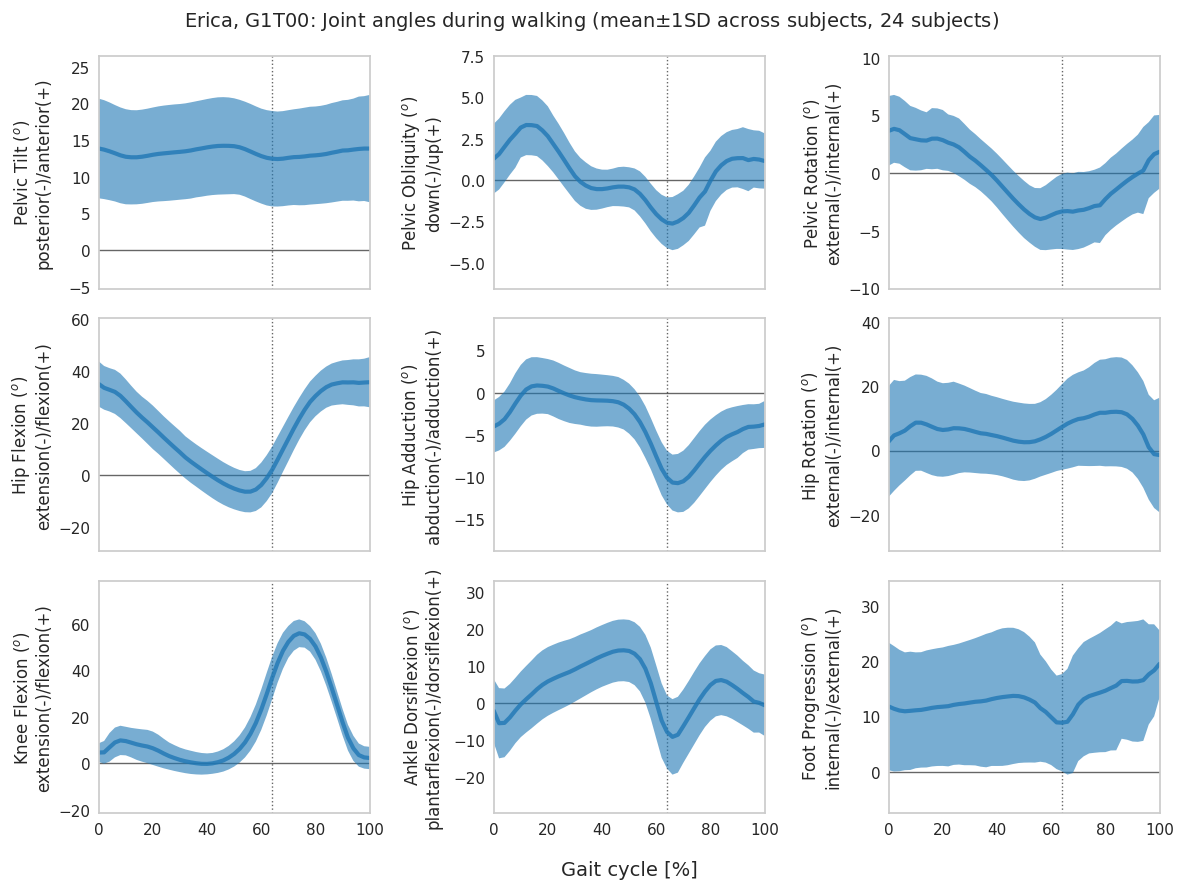

In [13]:
dam = da.reduce(np.nanmean, dim='Subject')
dastd = da.reduce(np.nanstd, ddof=1, dim='Subject')#/np.sqrt(NS)

plot_subjects_m_std(dam, dastd, path2, metadata2, group, assessment, NS)

### GPS calculation

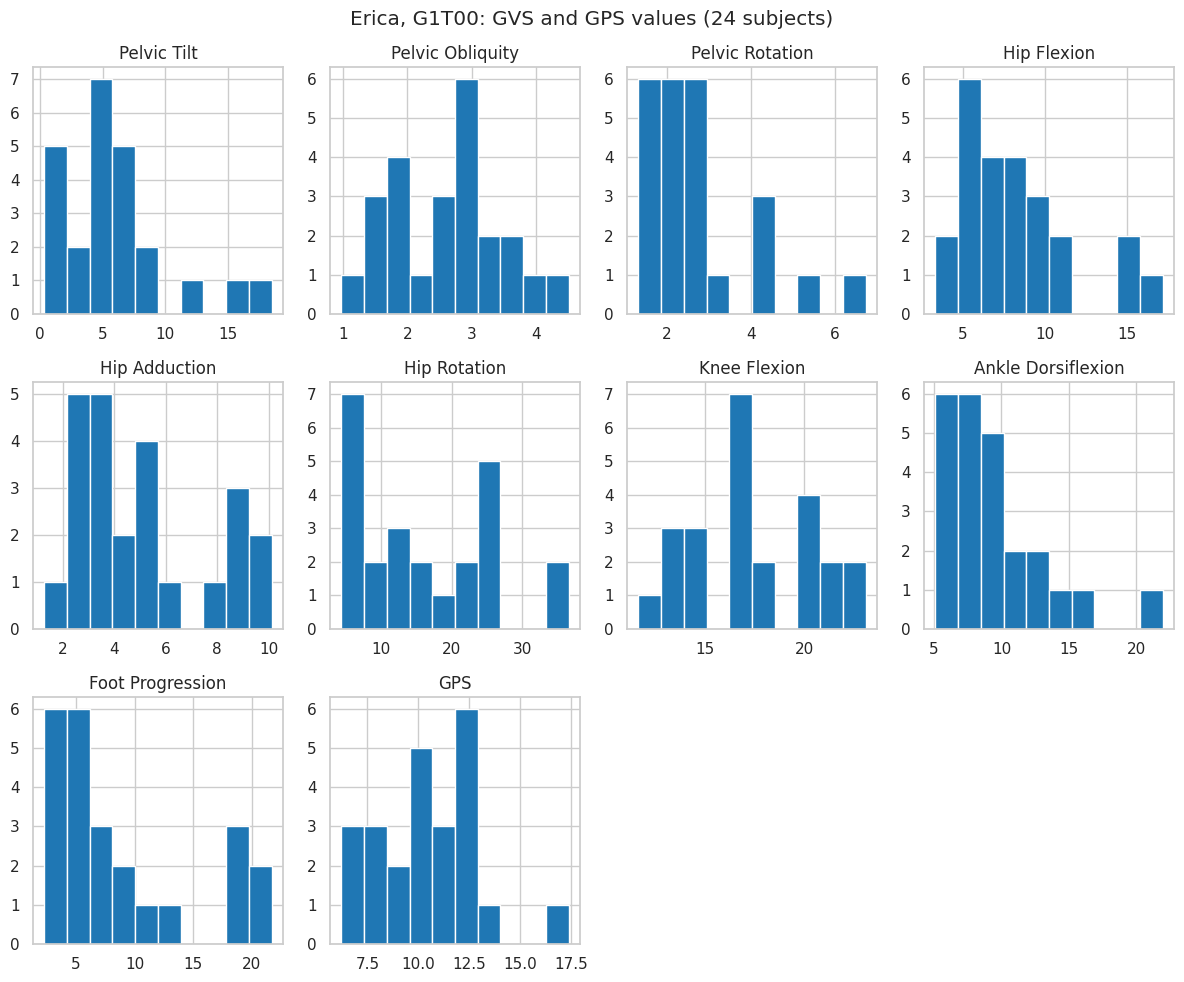

In [14]:
subjects = da.Subject.values
NS = subjects.size
time = da['Time'].values
gvs = np.full((NS, len(labels)), np.nan)
for s, subject in enumerate(subjects):
    x = da.sel(Subject=subject).values.reshape(time.size, 9)
    gvs[s, :-1] = RMSD(x, ref_data.values)

gvs[:, -1] = np.sqrt(np.mean(gvs[:, :-1]**2, axis=1))
gvs = pd.DataFrame(data=gvs, index=subjects, columns=labels)
gvs_m = np.sqrt(np.mean(gvs**2, axis=0))
gvs_std = np.sqrt(np.std(gvs**2, axis=0, ddof=1))
gvs_m = np.percentile(gvs, 50, axis=0)
gvs_std = np.percentile(gvs, [25, 75], axis=0)

gvs.hist(layout=(3, 4), figsize=(12, 10))
plt.suptitle(f'{path2.name}, G{group}{assessment}: GVS and GPS values ({NS} subjects)')
plt.tight_layout()

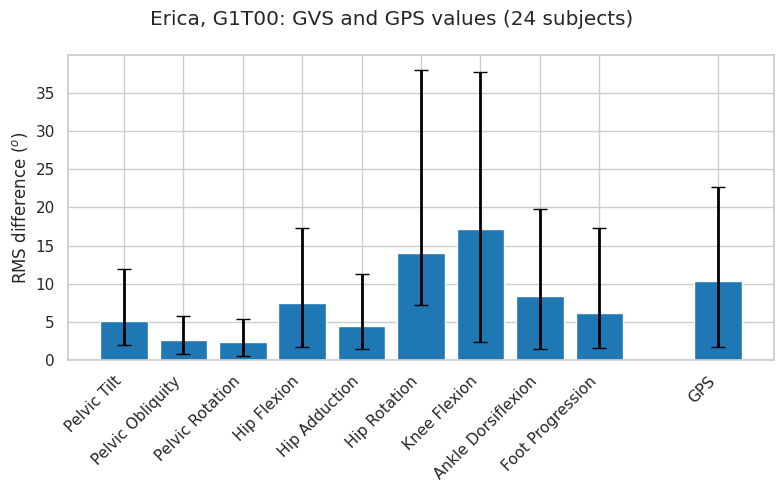

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5))
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 11]

axs.bar(x=x, height=gvs_m, yerr=gvs_std, width=.8, edgecolor=None, capsize=5)

axs.set_ylabel('RMS difference ($^o$)')
axs.set_xlabel('')
axs.xaxis.set_ticks(x)
axs.set_xticklabels(labels, rotation=45, ha='right')
axs.grid(True)
plt.suptitle(f'{path2.name}, G{group}{assessment}: GVS and GPS values ({NS} subjects)')
plt.tight_layout()
plt.show()